In [1]:
import torch # 导入pytorch
from torch import nn, optim # 导入神经网络与优化器对应的类
import torch.nn.functional as F
from torchvision import datasets, transforms 

In [3]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/AlexNet'

In [4]:
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Resize((224, 224)),
transforms.Normalize((0.5,), (0.5,))
])

In [5]:
batch_size=64
trainset = datasets.FashionMNIST(root=data_dir, download=True,train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True)


testset = datasets.FashionMNIST(root=data_dir, download=True,train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=64, shuffle=True)

In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
model = AlexNet()

In [8]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
import time
model = AlexNet()
def training(trainloader, testloader, lr, epochs):
  model.to('cuda') #如果不是gpu版本的pytorch，将这行注释掉
  # 定义损失函数为交叉熵
  criterion = nn.CrossEntropyLoss()
  # 优化方法为SDG，学习率为0.003
  optimizer = optim.SGD(model.parameters(), lr=lr)
  # 将每次训练的训练误差和测试误差存储在这两个列表里，后面绘制误差变化折线图用
  train_losses, test_losses = [], []
  start_time = time.time()
  print("------------训练开始:lr={}, epochs={}---------".format(lr, epochs))
  for e in range(epochs):
    running_loss = 0
  # 对训练集中的所有图片都过一遍
    for images, labels in trainloader:
      images = images.cuda() #如果不是gpu版本的pytorch,将这行注释掉
      labels = labels.cuda() #如果不是gpu版本的pytorch,将这行注释掉
      # 将优化器中的求导结果都设为0，否则会在每次反向传播之后叠加之前的
      optimizer.zero_grad()
      #对64张图片进行推断，计算损失函数，反向传播优化权重，将损失求和
      log_ps = model(images)
      loss = criterion(log_ps, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  # 每次学完一遍数据集，都进行以下测试操作
    else:
      test_loss = 0
      accuracy = 0
  # 测试的时候不需要开自动求导和反向传播
      with torch.no_grad():
  # 将模型转换为评估模式，在该模式下不会影响到训练
        model.eval()
  # 对测试集中的所有图片都过一遍
        for images, labels in testloader:
          images = images.cuda() #如果不是gpu版本的pytorch，将这行注释掉
          labels = labels.cuda() #如果不是gpu版本的pytorch，将这行注释掉
          # 对传入的测试集图片进行正向推断、计算损失，accuracy为测试集一万张图片中模型预测正确率
          log_ps = model(images)
          test_loss += criterion(log_ps, labels)
          '''这里代码有疑问'''
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class ==labels.view(*top_class.shape)
          # 等号右边为每一批64张测试图片中预测正确的占比
          accuracy +=torch.mean(equals.type(torch.FloatTensor))
          '''这里代码有疑问'''
        # 恢复Dropout
        model.train()
        # 将训练误差和测试误差存在两个列表里，后面绘制误差变化折线图用
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        info = "训练集学习次数: {}/{}.. ".format(e+1,epochs),"训练误差: {:.3f}..".format(running_loss/len(trainloader)),\
        "测试误差: {:.3f}..".format(test_loss/len(testloader)),"模型分类准确率:{:.3f}".format(accuracy/len(testloader))
        print(info)
  end_time = time.time()
  run_time = end_time - start_time
  return [lr, epochs, train_losses, test_losses, run_time]

In [10]:
%time [lr, epochs, train_losses, test_losses, run_time]=training(trainloader, testloader, 0.003, 15)

------------训练开始:lr=0.003, epochs=15---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


('训练集学习次数: 1/15.. ', '训练误差: 2.302..', '测试误差: 2.301..', '模型分类准确率:0.100')
('训练集学习次数: 2/15.. ', '训练误差: 2.299..', '测试误差: 2.293..', '模型分类准确率:0.147')
('训练集学习次数: 3/15.. ', '训练误差: 2.091..', '测试误差: 1.182..', '模型分类准确率:0.555')
('训练集学习次数: 4/15.. ', '训练误差: 0.924..', '测试误差: 0.807..', '模型分类准确率:0.706')
('训练集学习次数: 5/15.. ', '训练误差: 0.727..', '测试误差: 0.746..', '模型分类准确率:0.744')
('训练集学习次数: 6/15.. ', '训练误差: 0.648..', '测试误差: 0.625..', '模型分类准确率:0.764')
('训练集学习次数: 7/15.. ', '训练误差: 0.593..', '测试误差: 0.586..', '模型分类准确率:0.783')
('训练集学习次数: 8/15.. ', '训练误差: 0.554..', '测试误差: 0.533..', '模型分类准确率:0.799')
('训练集学习次数: 9/15.. ', '训练误差: 0.520..', '测试误差: 0.516..', '模型分类准确率:0.808')
('训练集学习次数: 10/15.. ', '训练误差: 0.492..', '测试误差: 0.484..', '模型分类准确率:0.821')
('训练集学习次数: 11/15.. ', '训练误差: 0.471..', '测试误差: 0.461..', '模型分类准确率:0.832')
('训练集学习次数: 12/15.. ', '训练误差: 0.450..', '测试误差: 0.438..', '模型分类准确率:0.839')
('训练集学习次数: 13/15.. ', '训练误差: 0.434..', '测试误差: 0.435..', '模型分类准确率:0.840')
('训练集学习次数: 14/15.. ', '训练误差: 0.422..', '测试误差: 0.405..', '模型分

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

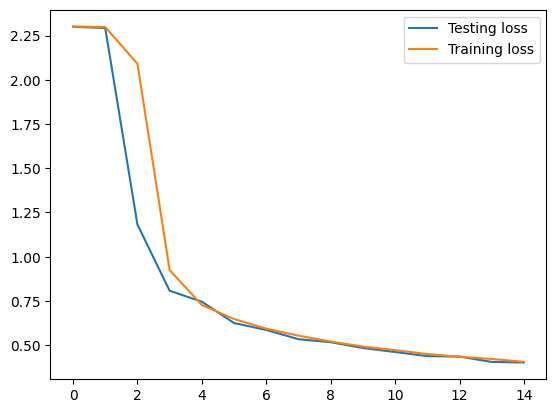

In [12]:
for i in range(len(test_losses)):
    test_losses[i] = test_losses[i].cpu()

plt.plot(test_losses, label='Testing loss')
plt.plot(train_losses, label='Training loss')
plt. legend()